In [1]:
import os

# 数据路径配置
train_data_path = "../data/riddles/zimi/zimi_train_data.csv"
label_to_index_path = "../data/results/label_to_index.json"
index_to_label_path = "../data/results/index_to_label.json"
model_save_path = "../models/structure_classifier/riddle_classifier.pth"
embedding_model_path = "BAAI/bge-small-zh-v1.5"  # 修改为你的模型路径

# 超参数配置
max_length = 50
batch_size = 16
learning_rate = 1e-5
num_epochs = 50
test_size = 0.2

# 检查并创建保存模型的目录
model_dir = os.path.dirname(model_save_path)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [2]:
import pandas as pd
import ast
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json


In [3]:
# 安全地将字符串转换为原始格式（列表或字典），对于无效格式返回原始值。
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val) if not pd.isna(val) else val
    except (ValueError, SyntaxError):
        return val

# 读取数据
zimi_df = pd.read_csv(train_data_path).dropna()
zimi_df['拆字'] = zimi_df['拆字'].apply(safe_literal_eval)
zimi_df['pronunciation_details'] = zimi_df['pronunciation_details'].apply(safe_literal_eval)
zimi_df.head(5)


,字符,笔画数,拼音,偏旁部首,频率,结构代码,拆字,结构方式,间架比例,char,index,pinyin,pronunciation_details,结构谜底,拆字谜底,谜底,字谜
0,当,6,dàng,彐,0,B0,[小 彐],上下结构,上下结构,当,418.0,dàng,"{'pinyin': 'dàng', 'explanations': [{'content'...",[上下],小彐,[上下]小彐,天空翱翔小，大地奔腾彐
1,泛,7,fàn,氵,1,H2,"[水 乏, 氵 乏]",左右结构,左窄右宽,泛,865.0,fàn,"{'pinyin': 'fàn', 'explanations': [{'content':...",[左右],水乏,[左右]水乏,梦想左眼水，现实右眼乏
2,所,8,suǒ,户,0,H1,"[戶 斤, 户 斤, 戸 斤]",左右结构,左右相等,所,1164.0,suǒ,"{'pinyin': 'suǒ', 'explanations': [{'content':...",[左右],戶斤,[左右]戶斤,左部分戶，右部分斤
3,孩,9,hái,子,1,H0,[子 亥],左右结构,左右结构,孩,1730.0,hái,"{'pinyin': 'hái', 'explanations': [{'content':...",[左右],子亥,[左右]子亥,左子右亥，互为表里
4,仇,4,qiú,亻,1,H2,"[人 九, 亻 九]",左右结构,左窄右宽,仇,133.0,qiú,"{'pinyin': 'qiú', 'explanations': [{'content':...",[左右],人九,[左右]人九,梦想左眼人，现实右眼九


In [4]:
data = zimi_df.copy()
riddles = data['字谜'].tolist()
answers = data['结构谜底'].tolist()

# 创建标签映射
unique_labels = list(set(answers))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# 保存标签映射
with open(label_to_index_path, 'w', encoding='utf-8') as f:
    json.dump(label_to_index, f, ensure_ascii=False, indent=4)

with open(index_to_label_path, 'w', encoding='utf-8') as f:
    json.dump(index_to_label, f, ensure_ascii=False, indent=4)


In [5]:
class RiddleStructureDataset(Dataset):
    def __init__(self, riddles, answers, label_to_index):
        self.riddles = riddles
        self.answers = answers
        self.label_to_index = label_to_index

    def __len__(self):
        return len(self.riddles)

    def __getitem__(self, idx):
        riddle = self.riddles[idx]
        answer = self.answers[idx]
        label_index = self.label_to_index[answer]

        return riddle, torch.tensor(label_index, dtype=torch.long)

# 自定义 collate 函数
def structure_collate_fn(batch):
    riddles = [item[0] for item in batch]
    labels = torch.stack([item[1] for item in batch], dim=0)
    return riddles, labels


In [6]:
# 数据集分割
riddles_train, riddles_val, answers_train, answers_val = train_test_split(riddles, answers, test_size=test_size, random_state=42)

# 创建数据加载器
train_dataset = RiddleStructureDataset(riddles_train, answers_train, label_to_index)
val_dataset = RiddleStructureDataset(riddles_val, answers_val, label_to_index)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=structure_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=structure_collate_fn)


In [7]:
class RiddleStructureClassifier(nn.Module):
    def __init__(self, embedding_model, num_labels):
        super(RiddleStructureClassifier, self).__init__()
        self.embedding_model = embedding_model
        self.dropout = nn.Dropout(0.3)
        self.classifier1 = nn.Linear(embedding_model.get_sentence_embedding_dimension(), 768)
        self.classifier2 = nn.Linear(768, num_labels)

    def forward(self, input_sentences):
        embeddings = self.embedding_model.encode(input_sentences, convert_to_tensor=True).to('cuda')
        x_1 = self.dropout(embeddings)
        x_2 = nn.ReLU()(self.classifier1(x_1))
        logits = self.classifier2(x_2)
        return logits
    
    def classify(self, riddles, index_to_label):
        self.eval()
        with torch.no_grad():
            logits = self(riddles)
            _, predicted_indices = torch.max(logits, 1)
            predicted_labels = [index_to_label[idx.item()] for idx in predicted_indices]
            return predicted_labels

# 加载预训练模型
sentence_model = SentenceTransformer(embedding_model_path).to('cuda')

# 创建分类器和优化器
num_labels = len(unique_labels)
classifier = RiddleStructureClassifier(sentence_model, num_labels).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)


2024-06-09 03:35:16.715567: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 03:35:16.758389: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 03:35:16.758426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 03:35:16.759178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 03:35:16.765085: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 03:35:16.765990: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [8]:
class RiddleStructureSolver:
    def __init__(self, model, classifier, train_loader, val_loader, criterion, optimizer, num_epochs=3, device='cuda'):
        self.model = model.to(device)
        self.classifier = classifier.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def train(self):
        for epoch in range(self.num_epochs):
            self.classifier.train()
            total_loss = 0
            for riddles, labels in self.train_loader:
                labels = labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.classifier(riddles).to(self.device)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            self.train_losses.append(total_loss)
            print(f'Epoch {epoch+1}, Total loss: {total_loss}')
            val_loss, val_accuracy = self.evaluate(self.val_loader)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_accuracy)

    def evaluate(self, loader):
        self.classifier.eval()
        total, correct = 0, 0
        total_loss = 0
        with torch.no_grad():
            for riddles, labels in loader:
                labels = labels.to(self.device)
                outputs = self.classifier(riddles).to(self.device)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Validation Loss: {total_loss}, Validation Accuracy: {accuracy}%')
        return total_loss, accuracy

    def save_model(self, path):
        torch.save(self.classifier.state_dict(), path)

    def load_model(self, path):
        self.classifier.load_state_dict(torch.load(path))

# 实例化 RiddleStructureSolver 并开始训练
solver = RiddleStructureSolver(
    model=sentence_model,
    classifier=classifier,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device='cuda'
)

solver.train()


Epoch 1, Total loss: 35.51640963554382
Validation Loss: 8.80023992061615, Validation Accuracy: 72.33009708737865%
Epoch 2, Total loss: 34.71811097860336
Validation Loss: 8.618757128715515, Validation Accuracy: 72.33009708737865%
Epoch 3, Total loss: 33.9126872420311
Validation Loss: 8.437519073486328, Validation Accuracy: 72.33009708737865%
Epoch 4, Total loss: 33.05972200632095
Validation Loss: 8.253040134906769, Validation Accuracy: 72.33009708737865%
Epoch 5, Total loss: 32.32059693336487
Validation Loss: 8.060881078243256, Validation Accuracy: 72.33009708737865%
Epoch 6, Total loss: 31.363301515579224
Validation Loss: 7.8629655838012695, Validation Accuracy: 72.33009708737865%
Epoch 7, Total loss: 30.446839690208435
Validation Loss: 7.6515989899635315, Validation Accuracy: 72.33009708737865%
Epoch 8, Total loss: 29.574914932250977
Validation Loss: 7.440024197101593, Validation Accuracy: 72.33009708737865%
Epoch 9, Total loss: 28.642979443073273
Validation Loss: 7.226121127605438, V

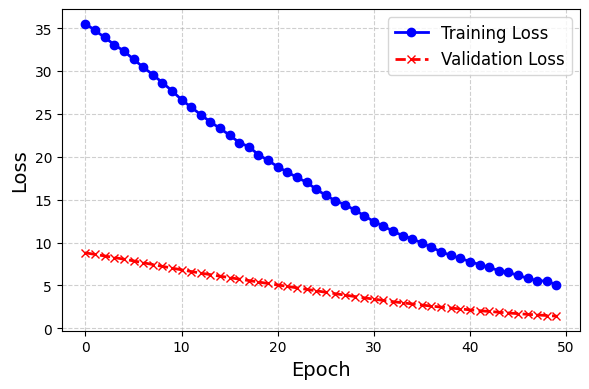

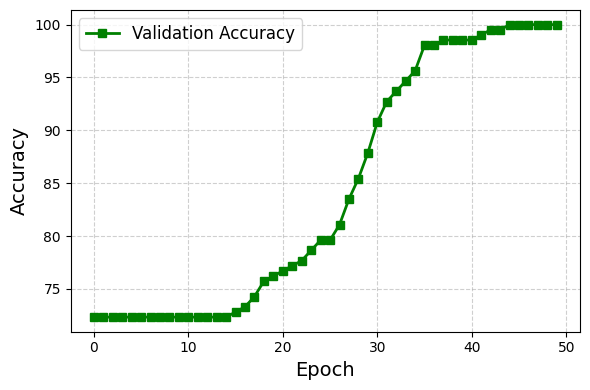

In [9]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', linewidth=2, marker='o')
    plt.plot(val_losses, label='Validation Loss', color='red', linestyle='--', linewidth=2, marker='x')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_accuracies(val_accuracies):
    plt.figure(figsize=(6, 4))
    plt.plot(val_accuracies, label='Validation Accuracy', color='green', linestyle='-', linewidth=2, marker='s')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_losses(solver.train_losses, solver.val_losses)
plot_accuracies(solver.val_accuracies)


In [10]:
solver.save_model(model_save_path)


In [11]:
# 加载预训练模型
sentence_model = SentenceTransformer(embedding_model_path).to('cuda')
classifier = RiddleStructureClassifier(sentence_model, num_labels).to('cuda')

# 加载模型
classifier.load_state_dict(torch.load(model_save_path))

# 测试分类器
riddles_to_classify = ['上边是天，下边是地', '上有天，下有地']
predicted_labels = classifier.classify(riddles_to_classify, index_to_label)

for riddle, label in zip(riddles_to_classify, predicted_labels):
    print(f"Riddle: {riddle} --> Predicted Label: {label}")


Riddle: 上边是天，下边是地 --> Predicted Label: [上下]
Riddle: 上有天，下有地 --> Predicted Label: [上下]
